## Intro to gaussian processes with GPyTorch!

Author: Johan Thor with code proudly stolen from Simon Hedström



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use("sodra1.mplstyle")


import torch
import torch.nn as nn

import gpytorch


In [2]:
# Below functions are written by Simon:


def delinearize(x):
    """Performs a linear regression and subtracts it from the signal."""
    k, m = np.polyfit(np.arange(len(x)), x, 1)
    return x - (k * np.arange(len(x)) + m)


def standardize(x):
    """Standardizes the signal using the sample mean and standard deviation."""
    std = np.std(x)
    if std == 0:
        std = 1
    return (x - np.mean(x)) / std


# Creating our initial problem

We generate the following signals $s_i$:
1. Random walk. Exponentially smoothed with a factor of $\frac{1}{30}$. Delinearized. Standardized. 
2. Sine wave with boolean logic $sin(t) > 0$. Standardized.
    
    
We construct our prediction target $y = standardize(s_1 + s_2)$.   
On top of that we also distort out target by adding noise $v \sim exp(\frac{1}{4})$

In [5]:
# Reproducibility:
torch.manual_seed(42)

# Set some constants:
noise_factor = 1 / 20
N = 10_000
num_train = 4 * N // 8
dt = 0.01

# Create some signals:

# Time
t = dt * torch.arange(N)
# x = torch.linspace(0, 1, N)

# Signal 1
signal1 = np.cumsum(np.random.randn(N))
signal1 = pd.Series(signal1).ewm(alpha=1 / 30).mean().values
signal1 = standardize(delinearize(signal1))
signal1 = torch.tensor(signal1)

# Signal 2
signal2 = torch.sin(t) > 0

# Target
target = signal1 + signal2

# Create some normally distributed noise:
noise = torch.randn(len(t))
target += noise * noise_factor

# Let the tensor x be the two features, i.e. signal1 and signal2
# to predict from:

x = torch.stack([signal1, signal2]).T

# Create train and test sets:
t_train = t[:num_train]
t_test = t[num_train:]

x_train = x[:num_train]
y_train = target[:num_train]

x_test = x[num_train:]
y_test = target[num_train:]

# Create a target signal:
# target = torch.cumsum(torch.randn(len(x_train_tens)), -1)


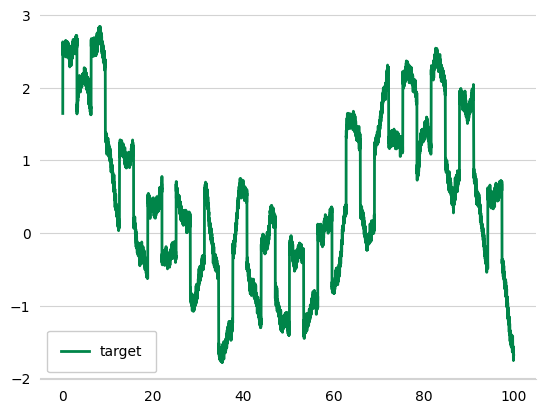

In [7]:
# plt.plot(target.cpu().numpy())
# plt.plot(noise.cpu().numpy())
# plt.plot(t.numpy(), signal1, color="mediumseagreen", label="s1")
# plt.plot(t.numpy(), signal2.numpy(), color="orangered", label="s2")
plt.plot(t, target, label="target")

# plt.ylim(-1, 1)
plt.legend(loc="lower left")


(array([  1.,   1.,   4.,   0.,   5.,   6.,  17.,  18.,  39.,  41.,  57.,
        103., 114., 154., 211., 275., 313., 387., 441., 544., 562., 596.,
        597., 633., 615., 616., 574., 496., 507., 466., 340., 306., 242.,
        190., 149., 129.,  93.,  60.,  30.,  21.,  20.,  14.,   6.,   3.,
          2.,   1.,   0.,   0.,   0.,   1.]),
 array([-3.83253169, -3.67146325, -3.51039505, -3.34932661, -3.18825841,
        -3.02718997, -2.86612177, -2.70505333, -2.54398489, -2.38291669,
        -2.22184825, -2.06078005, -1.89971161, -1.73864329, -1.57757497,
        -1.41650665, -1.25543821, -1.09436989, -0.93330157, -0.77223325,
        -0.61116493, -0.45009658, -0.28902823, -0.12795989,  0.03310845,
         0.19417679,  0.35524514,  0.51631349,  0.67738181,  0.83845013,
         0.99951851,  1.16058683,  1.32165515,  1.48272347,  1.64379179,
         1.80486023,  1.96592855,  2.12699676,  2.2880652 ,  2.44913363,
         2.61020184,  2.77127028,  2.93233848,  3.09340692,  3.25447536,
 

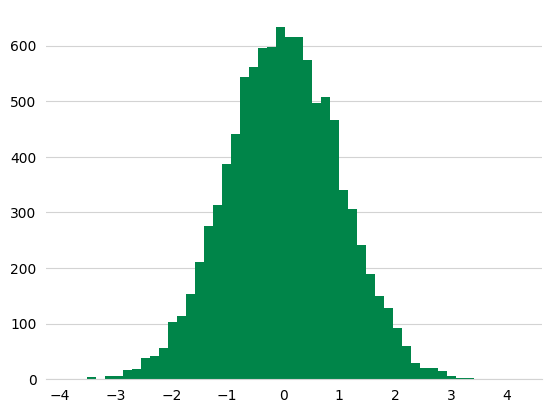

In [4]:
plt.hist(noise.cpu().numpy(), bins=50)


In [5]:
# We will use the simplest form of GP-model, exact inference.
# The GP-model is layed out as a common PyTorch-model with an
# init and forward-method:

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, x_train, target_train, likelihood):
        super(ExactGPModel, self).__init__(x_train, target_train, likelihood)
        # Assume constant mean:
        self.mean_module = gpytorch.means.ConstantMean()
        # We use the RBF-kernel for this, not the most intuitive given
        # the way the signal looks, but RBF is the most used one.
        # We also use "ScaleKernel" as that allows us to add a constant
        # to multiply the covariant matrix by:
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


In [6]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_train, y_train, likelihood)


In [7]:
# Move to GPU, if possible:
if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()
    t_train = t_train.cuda()
    t_test = t_test.cuda()
    x_train = x_train.cuda()
    y_train = y_train.cuda()
    x_test = x_test.cuda()


In [8]:
training_iter = 50

# Find optimal model hyperparameters, so put the model in training mode:
model.train()
likelihood.train()

# Use the adam optimizer:
optimizer = torch.optim.Adam(
    model.parameters(), lr=0.05
)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood:
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(x_train)

    # Calc loss and backprop gradients
    loss = -mll(output, y_train)

    # Do back-prop:
    loss.backward()
    print(
        "Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f"
        % (
            i + 1,
            training_iter,
            # loss.mean().item(),
            loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item(),
        )
    )
    optimizer.step()


Iter 1/50 - Loss: 0.747   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.729   lengthscale: 0.718   noise: 0.669
Iter 3/50 - Loss: 0.710   lengthscale: 0.744   noise: 0.644
Iter 4/50 - Loss: 0.692   lengthscale: 0.771   noise: 0.621
Iter 5/50 - Loss: 0.673   lengthscale: 0.798   noise: 0.598
Iter 6/50 - Loss: 0.654   lengthscale: 0.825   noise: 0.576
Iter 7/50 - Loss: 0.634   lengthscale: 0.853   noise: 0.554
Iter 8/50 - Loss: 0.615   lengthscale: 0.881   noise: 0.533
Iter 9/50 - Loss: 0.595   lengthscale: 0.910   noise: 0.513
Iter 10/50 - Loss: 0.576   lengthscale: 0.939   noise: 0.493
Iter 11/50 - Loss: 0.556   lengthscale: 0.968   noise: 0.474
Iter 12/50 - Loss: 0.536   lengthscale: 0.997   noise: 0.455
Iter 13/50 - Loss: 0.515   lengthscale: 1.027   noise: 0.437
Iter 14/50 - Loss: 0.495   lengthscale: 1.057   noise: 0.419
Iter 15/50 - Loss: 0.474   lengthscale: 1.087   noise: 0.402
Iter 16/50 - Loss: 0.453   lengthscale: 1.117   noise: 0.385
Iter 17/50 - Loss: 0.432   length

In [9]:
# Get into evaluation (predictive posterior) mode:
model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad():  # , gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(x_test))


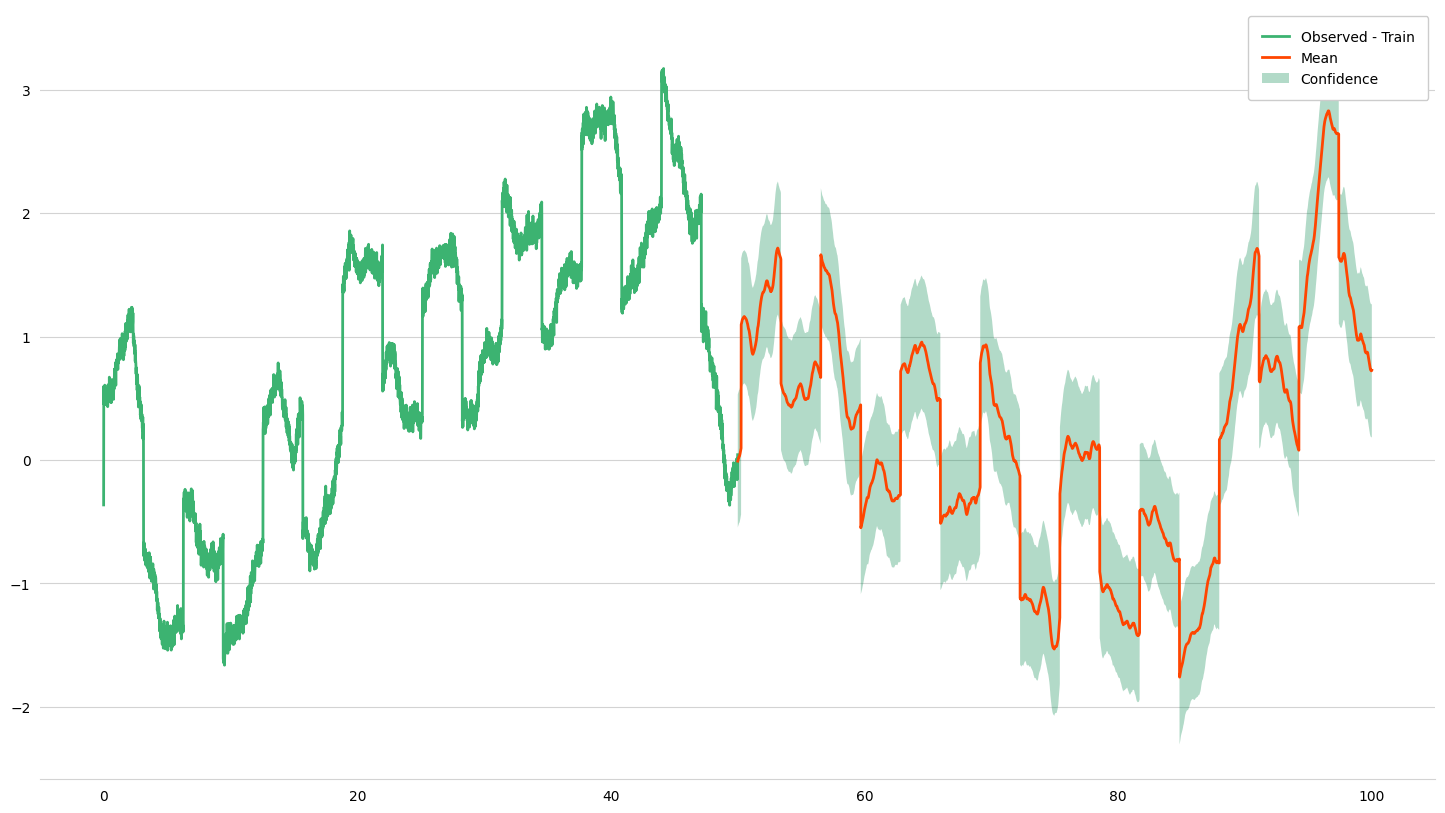

In [10]:
with torch.no_grad():
    # Initialize plot
    fig, ax = plt.subplots(1, 1, figsize=(18, 10))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    ax.plot(t_train.cpu().numpy(), y_train.cpu().numpy(), color="mediumseagreen")

    # Plot predictive means:
    ax.plot(t_test.cpu().numpy(), observed_pred.mean.cpu().numpy(), color="orangered")

    # Shade between the lower and upper confidence bounds
    ax.fill_between(
        t_test.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.3
    )
    # ax.set_ylim([-3, 3])
    ax.legend(["Observed - train", "Mean", "Confidence"])
